Imports.

In [168]:
from enum import Enum
from typing import NamedTuple
import numpy as np
import math
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Input, UpSampling2D, ZeroPadding2D, \
                         Cropping2D, Reshape, Layer
import keras
from keras import backend as K
from numba import njit
from skimage.filters import gabor_kernel
from keras.utils import conv_utils
from keras import activations
from keras import initializers
from keras import regularizers
from keras import constraints
from keras.engine.base_layer import InputSpec

Definições, inicializações e funções utilitárias.

In [29]:
#The tolerance for floating pointer comparison
epsilon = 0.000001

#The complexity of the variogram models
numberOfNestedStructures = 4
numberOfParametersPerNestedStructure = 4 #ATTENTION: if you change this value, you must change the makeVariogramModelSurface() function accordingly
totalNumberOfParameters = numberOfNestedStructures * numberOfParametersPerNestedStructure

#The target sill for the variogram models
sill = 0.64

#The range for the longest structure allowed in the variogram models
maxAxis = 50.0

class StructureType(Enum):
    Spheric     = 1
    Exponential = 2
    Gaussian    = 3
    
class EllipsoidParameters(NamedTuple):
    Azimuth      : float
    SemiMajorAxis: float
    SemiMinorAxis: float

class GridParameters(NamedTuple):
    X0: float
    Y0: float
    DX: float
    DY: float
    NI: int
    NJ: int

def getExtent2D( gridParameters : GridParameters ) -> np.array :
    gridCornerX = gridParameters.X0 - gridParameters.DX/2;
    gridCornerY = gridParameters.Y0 - gridParameters.DY/2;
    return [
           gridCornerX,
           gridCornerX + gridParameters.DX*gridParameters.NI,
           gridCornerY,
           gridCornerY + gridParameters.DY*gridParameters.NJ
           ]

def getGridParameters() -> GridParameters :
    return GridParameters( X0=-50., Y0=-50., 
                           DX=1,    DY=1, 
                           NI=100,  NJ=100 )    

Função gera superfície variográfica

In [30]:
@njit
def makeVariographicSurface( structureType       : StructureType, 
                             ellipsoidParameters : EllipsoidParameters, 
                             contribution        : float,
                             gridParameters      : GridParameters ) -> np.array :
   #NOTA VARIAVEIS COM [0] APARENTEMENTE DE FORMA DESNECESSARIA
   #sem isso dá erro de tipo não reconhecido (array) ao tentar usar com o JIT do Numba.
   #
   #Cria o numpy.array seguindo os parâmetros do grid.
   grid = np.zeros(( gridParameters.NI, gridParameters.NJ ));
   #Check for null structure
   if( contribution[0] < epsilon or 
       ellipsoidParameters.SemiMajorAxis[0] < epsilon or 
       ellipsoidParameters.SemiMinorAxis[0] < epsilon ) :
       return grid;
   #Obtem parâmetros geométricos
   a = ellipsoidParameters.SemiMajorAxis;
   b = ellipsoidParameters.SemiMinorAxis;
   c = contribution;                                       #contribution to semivariance
   theta = ellipsoidParameters.Azimuth/180.0 * math.pi; #azimuth
   xc = gridParameters.X0 - gridParameters.DX/2 + gridParameters.DX*gridParameters.NI/2; #center of the grid
   yc = gridParameters.Y0 - gridParameters.DY/2 + gridParameters.DY*gridParameters.NJ/2; #center of the grid
   #Calcula o variograma em cada célula do grid   
   for j in range( gridParameters.NJ ) :
      for i in range( gridParameters.NI ) :
         xCell = gridParameters.X0 + gridParameters.DX * i;
         yCell = gridParameters.Y0 + gridParameters.DY * j;
         x = (xCell - xc) * math.cos(theta[0]) - (yCell - yc) * math.sin(theta[0]);
         y = (xCell - xc) * math.sin(theta[0]) + (yCell - yc) * math.cos(theta[0]);
         modulusSquared = (x/a)*(x/a) + (y/b)*(y/b);
         h = math.sqrt( modulusSquared[0] );
         if( h >= 0. and h <= 1. ) :
            semivariance = c * (3*h/2.-math.pow(h, 3)/2.);
         else :
            semivariance = c;
         grid[i,j] = semivariance[0];
   #retorna o grid
   return grid;

Função para gerar a superfície de um modelo variográfico de 4 estruturas

In [31]:
# The parameters must be a linear 16-element array of floats in the following order:
# azimuth, semi-major axis, semi-minor axis, contribution, azimuth, ...
# for four structures.  Models with less than for structures can be specified with all-zero parameters
def makeVariogramModelSurface( parameters : np.array ) -> np.array :
    gridParameters = getGridParameters()
    variogramModelSurface = np.zeros(( gridParameters.NI, gridParameters.NJ ));
    for i in range( numberOfNestedStructures ) :
        variogramModelSurface += \
            makeVariographicSurface( structureType = StructureType.Spheric, 
                                     ellipsoidParameters = EllipsoidParameters( Azimuth      =parameters[i*numberOfParametersPerNestedStructure+0], 
                                                                                SemiMajorAxis=parameters[i*numberOfParametersPerNestedStructure+1], 
                                                                                SemiMinorAxis=parameters[i*numberOfParametersPerNestedStructure+2] ), 
                                     contribution=parameters[i*numberOfParametersPerNestedStructure+3],
                                     gridParameters = gridParameters )
    return variogramModelSurface;


Função para gerar um kernel Gabor 2D (parte real ou imaginária) dados seus parâmetros.

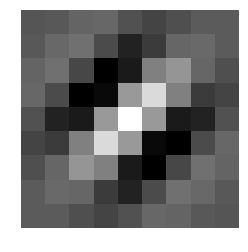

In [329]:
# gridSize: the dimensions of the resulting kernel in pixels.
# angle: the orientation angle of the Gabor wavelet in radians.
# lambd: the wavelength of the Gabor wavelet in pixels.
# sigmaX: the standard deviation of the Gaussian envelope in pixels along the angle azimuth.
# ratioSigmaXY: the ratio of the standard deviations of the Gaussian envelope alonge the 
#               angle azimuth and the orthogonal azimuth.
# phase: the phase of the Gabor wavelet with respect to the center of the kernel in radians.
# func: the trigronometric function to use.  Set cosine to get the real part and sine to get the
#       imaginary part of the Gabor kernel.
def makeGabor( gridSize, angle, lambd, sigmaX, ratioSigmaXY, phase, func=np.cos ):
    if not ( gridSize[0]%2 and gridSize[1]%2 ):
        raise ValueError('makeGabor(): dimensions must be odd numbers.')
    radius = (int(gridSize[0]/2.0), int(gridSize[1]/2.0))
    [x, y] = np.meshgrid(range(-radius[0], radius[0]+1), range(-radius[1], radius[1]+1))

    x1 = x * np.cos(angle) + y * np.sin(angle)
    y1 = -x * np.sin(angle) + y * np.cos(angle)
    
    return np.exp( - (x1**2 + ratioSigmaXY**2*y1**2)/(2*sigmaX**2)) * func(2*np.pi*(x1/lambd) + phase) 
        
# change func to "cos" to get the real part Gabor or to "sin" to get the imaginary part Gabor
g = makeGabor(gridSize=(9,9), angle= 45*np.pi/180, lambd=4.0, sigmaX=2.0, ratioSigmaXY=1.0, phase=0.0, func=np.cos ) 
plt.figure();
plt.axis('off')
plt.imshow(g, cmap=plt.gray())

Gerar estruturas variográficas simples e seus quatro parâmetros.

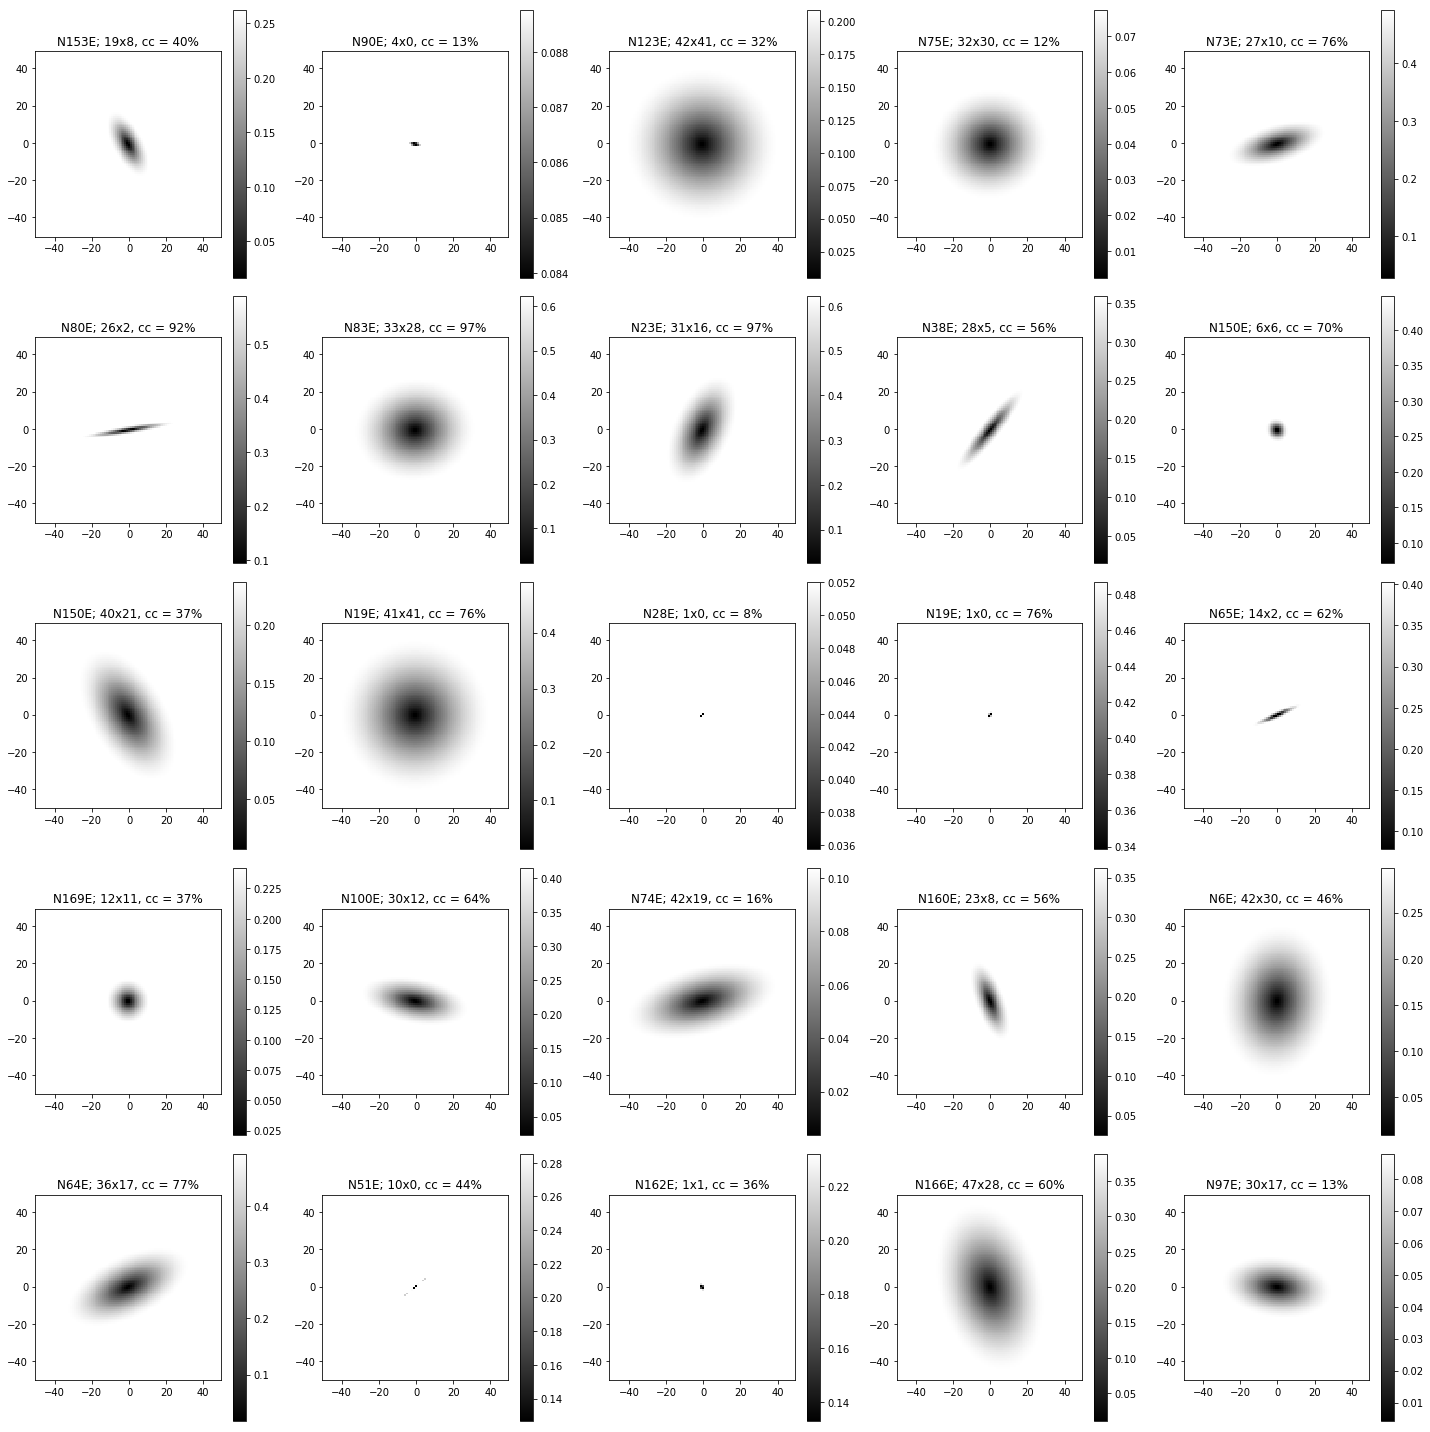

In [33]:
#The number of random variogram structures to generate
nStru = 40

#Allocate a volume for the stack of all variogram structures nStru * 100 * 100
allStructures = np.zeros(( nStru, getGridParameters().NI, getGridParameters().NJ))

#Allocate the stack of variographic parameters per structure nStru * 4 * 1
allParameters = np.zeros(( nStru, numberOfParametersPerNestedStructure ))

#Generate the variogram structures for training
for iStructure in range(nStru):
    
    #Radomize the azimuth (N000E through N180E)
    az = np.random.rand(1, 1)
    
    #Randomize the semi-major axis
    a = np.random.rand(1, 1)

    #Randomize the semi-minor axis such that they are necessarily smaller than the semi-major axis
    b = a * np.random.rand(1, 1)
    
    #Randomize the contribution as a 0.0-1.0 fraction of the expected variogram model sill
    cc = np.random.rand(1, 1) 
    
    #Linearize the array of variographic parameters
    linearArrayOfParametersUnitized =  np.column_stack( (az, a, b, cc) ).\
                                           reshape(numberOfParametersPerNestedStructure,1)
    linearArrayOfParametersFullScale = np.column_stack( (az*180, a*maxAxis, b*maxAxis, cc*sill) ).\
                                           reshape(numberOfParametersPerNestedStructure,1)
    
    #Make variogram structure
    variogramStructure = \
        makeVariographicSurface( structureType = StructureType.Spheric, 
                                 ellipsoidParameters = EllipsoidParameters( Azimuth      =linearArrayOfParametersFullScale[0], 
                                                                            SemiMajorAxis=linearArrayOfParametersFullScale[1], 
                                                                            SemiMinorAxis=linearArrayOfParametersFullScale[2]), 
                                 contribution=linearArrayOfParametersFullScale[3],
                                 gridParameters = getGridParameters() )
   
    #Stack the variogram structure
    allStructures[iStructure,:,:] = variogramStructure
    
    #Stack the linearized variographic parameters
    allParameters[iStructure,:] = linearArrayOfParametersUnitized.reshape((numberOfParametersPerNestedStructure,))


#Prepare a plot area measuring 5 by 5 figures, each measuring 20x20
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(20, 20))

#Plot the first 25 variogram surfaces to check data
iStru = int(0)
for ax in axs.flat:

    #plot the variogram surface
    mappable = ax.imshow( allStructures[iStru,:,:], 
                    interpolation='none',
                    extent=getExtent2D( getGridParameters() ))
    fig.colorbar(mappable, ax=ax)
    ax.set_title( "N" + str(int(allParameters[iStru,0]*180)) + "E; " 
                      + str(int(allParameters[iStru,1]*maxAxis)) + "x"
                      + str(int(allParameters[iStru,2]*maxAxis)) + ", cc = "
                      + str(int(100*allParameters[iStru,3])) + "%" )
    
    #Increment the synthetic structure index/count
    iStru = iStru + 1
    
#Lay out the plots
plt.tight_layout()
plt.show()



Define uma camada convolutiva cujos parâmetros aprendíveis são os de um núcleo Gabor 2D, qual sejam: azimute, frequencia (escala), média ao longo do semieixo maior, média ao longo do semieixo menor, desvio padrão ao longo do semieixo maior e desvio padrão ao longo do semieixo menor.  Médias e desvios são os parâmetros de uma superfície Gaussiana que envelopa a superfície senóide de determinada frequência e orientada ao azumute dado.

In [336]:
# This was based on Keras' _Conv class: https://github.com/keras-team/keras/blob/master/keras/layers/convolutional.py

class GaborLayer(Layer):

    def __init__(self, 
                 filters,
                 kernel_size,
                 activation,
                 strides=1,
                 padding='valid',
                 data_format=None, #None means 'channels_last'
                 dilation_rate=1,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 **kwargs):
        
        super(GaborLayer, self).__init__(**kwargs)
        self.rank = 2
        self.filters = filters
        self.kernel_size = conv_utils.normalize_tuple(kernel_size, self.rank,
                                                      'kernel_size')
        self.strides = conv_utils.normalize_tuple(strides, self.rank, 'strides')
        self.padding = conv_utils.normalize_padding(padding)
        self.data_format = K.normalize_data_format(data_format)
        self.dilation_rate = conv_utils.normalize_tuple(dilation_rate, self.rank,
                                                        'dilation_rate')
        self.activation = activations.get(activation)
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.bias_constraint = constraints.get(bias_constraint)
        self.input_spec = InputSpec(ndim=self.rank + 2)

    def build(self, input_shape):
        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1
        if input_shape[channel_axis] is None:
            raise ValueError('The channel dimension of the inputs '
                             'should be defined. Found `None`.')
        input_dim = input_shape[channel_axis]
        
        self.input_dim = input_dim #get the number of 2D grids in the input tensor
        
        kernel_shape = self.kernel_size + (input_dim, self.filters)

        #The "kernel" is actually a set of azimuth/scale pairs that are 
        #the parameters for each Gabor filter (the actual kernels).
        self.kernel = self.add_weight(shape= ( self.filters, 2 ),
                                      initializer=self.kernel_initializer,
                                      name='Gabor_parameters',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        self.bias = None
        # Set input spec.
        self.input_spec = InputSpec(ndim=self.rank + 2,
                                    axes={channel_axis: input_dim})
        self.built = True

    def call(self, inputs):
        
        ##################Generate the Gabor kernels from the learned Gabor parameters################
        #---Create a NumPy array with the values of the kernel tensor to be.
        gaborKernelStackShape = list( self.kernel_size )
        gaborKernelStackShape.append( self.input_dim ) #self.input_dim is the number of 2D grids in the input tensor
        gaborKernelStackShape.append( self.filters ) #self.filters is the number of 2D grids in the output tensor
        gaborKernels = np.zeros( tuple( gaborKernelStackShape ) )
        #---The array dimensions are: 1st dimension: number of cells in east-west direction of the 2D grids
        #                             2nd dimension: number of cells in north-south direction of the 2D grids
        #                             3rd dimension: number of grids in the input tensor
        #                             4th dimension: number of grids in the outpyt tensor
        #          Hence, we need to generate a number of 2D Gabor kernels corresponding to the 4th dimension.
        #          The same 2D Gabor kernel is copied for all the 2D grids of the input tensor (number in
        #          the 3rd dimension).
        #---Get the pairs of learned Gabor kernel parameters (azimuths and scales)
        gaborParameters = K.get_value( self.kernel ) #get NumPy array of Gabor parameters from learned tensor.
        #---For each output 2D grid
        for iKernel in range( self.filters ):
            angle = gaborParameters[ iKernel ][0] #get azimuth parameter (orientation of Gabor wavelet)
            lambd = gaborParameters[ iKernel ][1] #get scale parameter (wavelenght of Gabor wavelet)
            #Make a Gabor kernel from the parameters
            gaborKernel = makeGabor( gridSize = self.kernel_size, \
                                     angle = angle, \
                                     lambd = lambd, \
                                     sigmaX = max(self.kernel_size)/5.0, \
                                     ratioSigmaXY = 1.0, \
                                     phase=0.0, \
                                     func=np.cos ) #cosine = real part of the Gabor kernel
            #Copy the Gabor kernel values to the array of values for the tensor to be
            for iInputTensor in range( self.input_dim ) :
                gaborKernels[ :, :, iInputTensor, iKernel ] = gaborKernel
                       
        #---Create the kernels tensor for the convolution framework
        gaborKernelsTensor = K.variable(value=gaborKernels, dtype=K.dtype( self.kernel ), name='gaborKernelsTensor') 
        ##############################################################################################

        #---Perform the 2D convolution between the input tensor and the kernels tensor to get the output tensor-----
        outputs = K.conv2d(
                inputs,
                #self.kernel, #<------ the generated Gabor kernels goes here, not the learned parameters directly.  
                gaborKernelsTensor, # Using this instead
                strides=self.strides,
                padding=self.padding,
                data_format=self.data_format,
                dilation_rate=self.dilation_rate)

        if self.activation is not None:
            return self.activation(outputs)
        return outputs

    def compute_output_shape(self, input_shape):
        if self.data_format == 'channels_last':
            space = input_shape[1:-1]
        elif self.data_format == 'channels_first':
            space = input_shape[2:]
        new_space = []
        for i in range(len(space)):
            new_dim = conv_utils.conv_output_length(
                space[i],
                self.kernel_size[i],
                padding=self.padding,
                stride=self.strides[i],
                dilation=self.dilation_rate[i])
            new_space.append(new_dim)
        if self.data_format == 'channels_last':
            return (input_shape[0],) + tuple(new_space) + (self.filters,)
        elif self.data_format == 'channels_first':
            return (input_shape[0], self.filters) + tuple(new_space)

    def get_config(self):
        config = {
            'filters': self.filters,
            'kernel_size': self.kernel_size,
            'strides': self.strides,
            'padding': self.padding,
            'data_format': self.data_format,
            'dilation_rate': self.dilation_rate,
            'activation': activations.serialize(self.activation),
            'kernel_initializer': initializers.serialize(self.kernel_initializer),
            'bias_initializer': initializers.serialize(self.bias_initializer),
            'kernel_regularizer': regularizers.serialize(self.kernel_regularizer),
            'bias_regularizer': regularizers.serialize(self.bias_regularizer),
            'activity_regularizer':
                regularizers.serialize(self.activity_regularizer),
            'kernel_constraint': constraints.serialize(self.kernel_constraint),
            'bias_constraint': constraints.serialize(self.bias_constraint)
        }
        base_config = super(_Conv, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))



In [337]:

input_layer = Input(shape=(getGridParameters().NI, getGridParameters().NJ, 1))
encoder = ZeroPadding2D(padding=((14,14),(14,14))) ( input_layer )
encoder = Conv2D(40, kernel_size=3, activation='relu', padding='same') ( encoder ) #camada convolutiva de 16 kernels (corresponde a 16 neurônios)
encoder = GaborLayer(20, kernel_size=9, activation='relu', padding='same') ( encoder ) #camada convolutiva de 16 kernels (corresponde a 16 neurônios)


#Cria a parte deconvolutiva da parte decodificadora
decoder = Conv2D(1, kernel_size=3, activation='sigmoid', padding='same') ( encoder ) 
decoder = Cropping2D(cropping=((14,14),(14,14))) ( decoder )

#Monta a arquitetura decoder completa
decoder_instance = Model(input_layer, decoder)

#Mostra o resumo da arquitetura
decoder_instance.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_145 (InputLayer)       (None, 100, 100, 1)       0         
_________________________________________________________________
zero_padding2d_145 (ZeroPadd (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d_220 (Conv2D)          (None, 128, 128, 40)      400       
_________________________________________________________________
gabor_layer_119 (GaborLayer) (None, 128, 128, 20)      40        
_________________________________________________________________
conv2d_221 (Conv2D)          (None, 128, 128, 1)       181       
_________________________________________________________________
cropping2d_53 (Cropping2D)   (None, 100, 100, 1)       0         
Total params: 621
Trainable params: 621
Non-trainable params: 0
_________________________________________________________________


Constrói uma rede para treinar a associação ( azimute, semieixo maior, semieixo menor, contribuição) --> estrutura imbricada.

In [338]:
#Normalizar os dados de entrada
#normalizer   = StandardScaler()
#X_norm = normalizer.fit_transform(X)
#ver se o normalizer traz para 0.0-1.0 mesmo
#normalizar as superfícies teóricas e o experimental na mesma escala (max de todos os mapas + experimental)
#colocar camadas de max/min pooling depois de cada camada convolutiva
#ver rede LeNet dado em um dos notebooks da aula.

#Dividir o conjunto total de superfícies variográficas e seus parâmetros em dois conjuntos:
#  1) O conjunto de treinamento, para o processamento do backpropagation.
#  2) O conjunto de teste, para aferição de métricas de acurácia da predição
trainParameters, testParameters, trainStructures, testStructures = \
      train_test_split(allParameters, allStructures, test_size=0.25, random_state=11111)
    
#Talvez tenha que rescalar os variogramas para 0.0-1.0

#Compatibiliza os dados de entrada para uso no Keras, que espera tensores (matrizes de ordem maior que 2)
#de ordem 4: # de imagens, dimensão I de cada imagem, dimensão J de cada imagem, # de canais em cada imagem
trainStructures = trainStructures.reshape(trainStructures.shape + (1,)) #(1,) significa uma tupla de um elemento
testStructures  = testStructures.reshape(testStructures.shape + (1,))

#compila o modelo, passando o algoritmo de otimização, a métrica para a função-objetivo e a métrica para aferir a acurácia
decoder_instance.compile(optimizer='adadelta', loss='mean_squared_error') #metrics=["accuracy"] não ajuda para regressões

#treina a rede
#25% do dado de entrada serão usados como conjunto de validação, ou seja, a cada passo (época),
#a função-objetivo é avaliada usando esses dados
#run_hist = model.fit(X, y, validation_split=0.15, epochs=20)
#Em uma rede autoencoder, tanto entradas quanto as saídas são imagens de mesma dimensão.
decoder_instance.fit(trainStructures, trainStructures,
                     epochs=10,
                     batch_size=128,
                     shuffle=True,
                     validation_data=(testStructures, testStructures))


ValueError: An operation has `None` for gradient. Please make sure that all of your ops have a gradient defined (i.e. are differentiable). Common ops without gradient: K.argmax, K.round, K.eval.

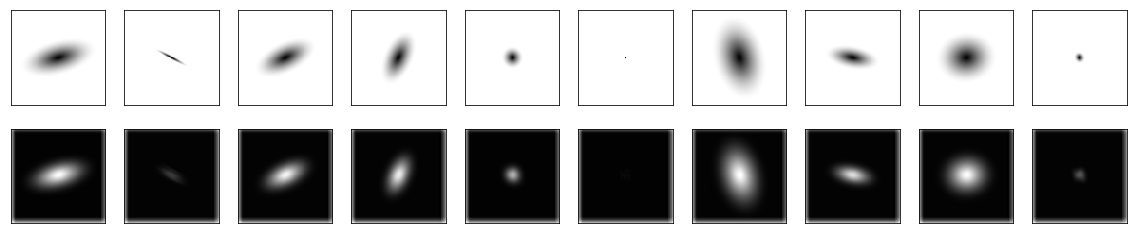

In [180]:
#teste a predição com os parametros de teste
decoded_imgs = decoder_instance.predict( testStructures )

nFigs = 10
plt.figure(figsize=(20, 4))
for i in range(nFigs):
    # display original
    ax = plt.subplot(2, nFigs, i+1)
    plt.imshow(testStructures[i].reshape(getGridParameters().NI, getGridParameters().NJ))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, nFigs, i + nFigs + 1)
    plt.imshow(decoded_imgs[i].reshape(getGridParameters().NI, getGridParameters().NJ))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()